In [11]:
# Workspace problem with several narrow gaps

import torch
import torch.nn as nn

from functools import partial
import numpy as np
from numpy.random import default_rng
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import gaussian_kde
import matplotlib.animation as animation
import sys
import time
import cv2
from celluloid import Camera
from IPython.display import HTML

sys.path.append('/home/oscar_palfelt/MSc_thesis/ompl/py-bindings')
from ompl import base as ob
from ompl import control as oc
from ompl import geometric as og

rng = default_rng(900)

cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")

In [2]:
# neural network parameters
mb_size = 256 # mini batch dim
h_Q_dim = 512*1 # encoder dim
h_P_dim = 512*1 # decoder dim

# problem dimsions
nDrawnSamples = 23 # number of dependent samples to draw during smapling (length of predicted control series)
nPreviousStates = 1 # number of previous states to condition on the steering prediction
dim = 7 # (truckX, truckY, truckYaw, truckX, trailerY, trailerYaw, steer)
dimGoal = 3
dimObs = 2
dimPredict = dim - 0 # predict truck (truckX, truckY, truckYaw, steer)
dataElements = (nDrawnSamples + nPreviousStates) * dim + dimGoal + dimObs # steer sample, current pose (3D: x,y,yaw), goal (3D), dimObs (2D x 3)

z_dim = 3 # latent dim
X_dim = nDrawnSamples*dimPredict
c_dim = dataElements - X_dim # dimension of conditioning variable

roadWidth = 0.12
c = [0.5, 0.5]

In [3]:
# define pytorch networks
# based on https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/.ipynb_checkpoints/01_Variational_AutoEncoder-checkpoint.ipynb

class Encoder(nn.Module):
    
    def __init__(self, input_dim=X_dim+c_dim, hidden_dim=h_Q_dim, latent_dim=z_dim):
        super(Encoder, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.z_mu = nn.Linear(hidden_dim, latent_dim)
        self.z_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):

        seq = self.network(x)

        return self.z_mu(seq), self.z_logvar(seq)


class Decoder(nn.Module):
    def __init__(self, latent_dim=z_dim+c_dim, hidden_dim=h_P_dim, output_dim=X_dim):
        super(Decoder, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        
        return self.network(x)


class NeuralNetwork(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(NeuralNetwork, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
    
    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(mean).to(DEVICE)        # sampling epsilon        
        z = mean + torch.exp(0.5 * logvar) * epsilon       # reparameterization trick
        return z

    def forward(self, x, c, encode=True):
        if encode:

            z_mu, z_logvar = self.Encoder(torch.cat((x, c), dim=1))
            z = self.reparameterization(z_mu, z_logvar)

            y = self.Decoder(torch.cat((z, c), dim=1))

            return y, z_mu, z_logvar
        else:
            z = x
            y = self.Decoder(torch.cat((z, c), dim=1))    

            return y


network = torch.load('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/truck_trailer/networks/intersect_23.pt', map_location=torch.device(DEVICE))

In [4]:
# read in data from .txt file, re-arrange to allow drawing multiple depedent samples

filename = '/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/truck_trailer/motion_planning/data/mapC_data_10kPlans'
rawdata = np.genfromtxt(filename, delimiter=',', dtype='d', usecols=[0,1,2,3,4,5,6,10,11,12,13,14]) # disregard init

_, pathsIdx = np.unique(rawdata[:,dim:], axis=0, return_index=True)
pathsIdx.sort()

pathsLengths = np.roll(pathsIdx, -1) - pathsIdx
pathsLengths[-1] = rawdata.shape[0] - np.sum(pathsLengths[:-1])

validLengthsIdx = np.argwhere(pathsLengths >= nPreviousStates + nDrawnSamples) 
validPlansIdx = pathsIdx[validLengthsIdx]

data = np.zeros(shape=(1, dataElements)) # steering angles, samples (x,y,yaw), goal(x,y,yaw)
tempdata = np.copy(data)
for ci, i in enumerate(validPlansIdx[:-1].reshape(-1)):
    for j in range(pathsLengths[ci] - (nPreviousStates + nDrawnSamples - 1)):
        sample = np.arange(start=j, stop=j + nPreviousStates + nDrawnSamples)

        if np.any(np.abs(np.diff(rawdata[i + sample, 0])) > 0.05) or np.any(np.abs(np.diff(rawdata[i + sample, 1])) > 0.05):
            break # ignore duplicate plans (data generation is not perfect)
        
        seqstates = rawdata[i + sample, :dim].reshape(1, (nPreviousStates + nDrawnSamples)*dim)
        if np.where(np.abs(seqstates[0, 4:(nPreviousStates + nDrawnSamples)*dim:dim]) < 3e-2)[0].shape[0] >= (nDrawnSamples + nPreviousStates) // 1.2:
            continue

        tempdata = np.vstack((tempdata, np.append(seqstates, rawdata[i, dim:].reshape(1, dimGoal+dimObs), axis=1))) 

        if ci % 500 == 0:
            data = np.vstack((data, tempdata[1:]))
            tempdata = np.zeros(shape=(1, dataElements))

data = data[1:]

rng.shuffle(data) # shuffle data (otherwise the data is sorted by obstacles/the map)

pathData = np.copy(data[:, :-dimObs])
obsData = np.copy(data[:, -dimObs:])

numEntries = pathData.shape[0]
print(numEntries)

14488


In [5]:
# split the inputs and conditions into test train (to be processed in the next step into an occupancy grid representation)

ratioTestTrain = 0.8;
numTrain = int(numEntries*ratioTestTrain)

x = pathData[:, dim * nPreviousStates:-dim+1:dim]
y = pathData[:, 1 + dim * nPreviousStates:-dim+2:dim]
yaw = pathData[:, 2 + dim * nPreviousStates:-dim+3:dim]
steer = pathData[:, 4 + dim * nPreviousStates:-dim+5:dim]
tx = pathData[:, 5 + dim * nPreviousStates:-dim+6:dim]
ty = pathData[:, 6 + dim * nPreviousStates:-dim+6:dim]
tyaw = pathData[:, 3 + dim * nPreviousStates:-dim+4:dim]

X = np.zeros(shape=(numEntries, X_dim))
X[:, ::dimPredict] = x
X[:, 1::dimPredict] = y
X[:, 2::dimPredict] = yaw
X[:, 3::dimPredict] = steer
X[:, 4::dimPredict] = ty
X[:, 5::dimPredict] = tx
X[:, 6::dimPredict] = tyaw

X_train = X[:numTrain]
X_test = X[numTrain:numEntries]

numTest = X_test.shape[0]

print(X_train.shape)

(11590, 161)


In [6]:
# generate conditioning variable

nextStates = pathData[:, nPreviousStates*dim:-dimGoal]

prevStatesConditions = pathData[:, :nPreviousStates * dim]
goalStateCondition = pathData[:, -dimGoal:]

conditionsOcc = np.copy(obsData)

cs = np.concatenate((prevStatesConditions, goalStateCondition, conditionsOcc), axis=1)

c_dim = cs.shape[1]
c_train = cs[0:numTrain,:]  
c_test = cs[numTrain:numEntries,:]

print(cs.shape)

(14488, 12)


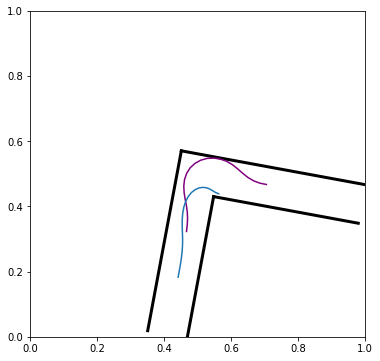

In [7]:
# Visualize data sample

i = np.random.randint(1,numEntries)

alpha1 = obsData[i, 0]
alpha2 = obsData[i, 1]
c = [0.5, 0.5]

a = c[0] + 0.5 * np.array([np.cos(alpha1), np.sin(alpha1)]) # line segment 1 end point
b = c[1] + 0.5 * np.array([np.cos(alpha2), np.sin(alpha2)]) # line segment 2 end point

sign = np.where(alpha1 < alpha2, 1, -1)
k = (1 / np.abs(np.sin(.5*(alpha1 - alpha2 + np.pi + np.pi) % (2 * np.pi) - np.pi)))

lcx = c[0] + sign * roadWidth / 2 * np.cos((alpha1 + alpha2)/2) * k
lcy = c[1] + sign * roadWidth / 2 * np.sin((alpha1 + alpha2)/2) * k
scx = c[0] - sign * roadWidth / 2 * np.cos((alpha1 + alpha2)/2) * k
scy = c[1] - sign * roadWidth / 2 * np.sin((alpha1 + alpha2)/2) * k

plt.figure(figsize=(6,6))
plt.plot([a[0] + roadWidth / 2 * np.sin(alpha1), scx], [a[1] - roadWidth / 2 * np.cos(alpha1), scy], color='k', linewidth=3)
plt.plot([a[0] - roadWidth / 2 * np.sin(alpha1), lcx], [a[1] + roadWidth / 2 * np.cos(alpha1), lcy], color='k', linewidth=3)
plt.plot([b[0] + roadWidth / 2 * np.sin(alpha2), lcx], [b[1] - roadWidth / 2 * np.cos(alpha2), lcy], color='k', linewidth=3)
plt.plot([b[0] - roadWidth / 2 * np.sin(alpha2), scx], [b[1] + roadWidth / 2 * np.cos(alpha2), scy], color='k', linewidth=3)
plt.plot(pathData[i, :-dim:dim], pathData[i, 1:-dim:dim], color='purple')
plt.plot(pathData[i, 5:-dim:dim], pathData[i, 6:-dim:dim], color='C0')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()

In [8]:
def dist2linesegment(p, a, b): # p: point, a: line end 1, b: line ned 2
    """
    # from https://stackoverflow.com/a/58781995

    Args:
        - p: np.array of single point, shape (2,) or 2D array, shape (x, 2)
        - a: np.array of shape (x, 2)
        - b: np.array of shape (x, 2)
    """

    # normalized tangent vectors
    d_ba = b - a
    d = np.divide(d_ba, (np.hypot(d_ba[:, 0], d_ba[:, 1])
                           .reshape(-1, 1)))

    # signed parallel distance components
    # rowwise dot products of 2D vectors
    s = np.multiply(a - p, d).sum(axis=1)
    t = np.multiply(p - b, d).sum(axis=1)

    # clamped parallel distance
    h = np.maximum.reduce([s, t, np.zeros(len(s))])

    # perpendicular distance component
    # rowwise cross products of 2D vectors  
    d_pa = p - a
    c = d_pa[:, 0] * d[:, 1] - d_pa[:, 1] * d[:, 0]

    return np.hypot(h, c)

In [9]:
class VehicleState():
    def __init__(self):
        self.x = 0
        self.y = 0
        self.yaw = 0
        self.v = 0

saving animation


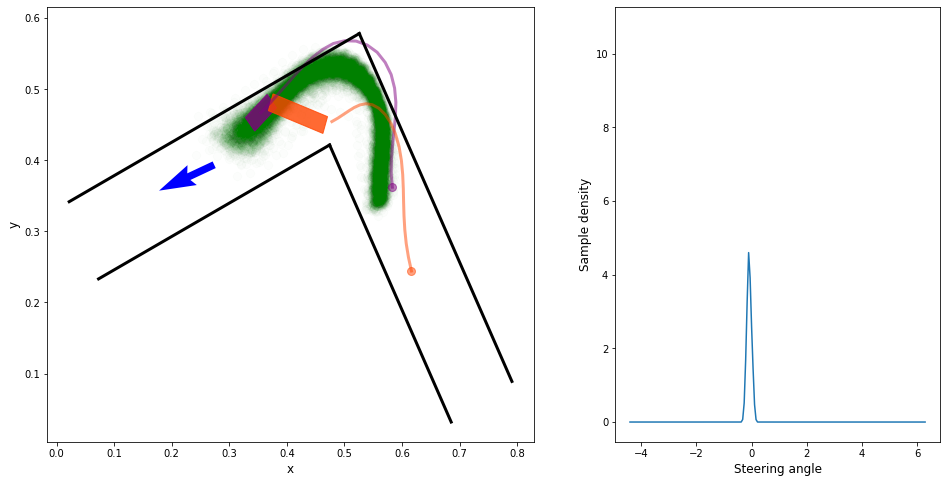

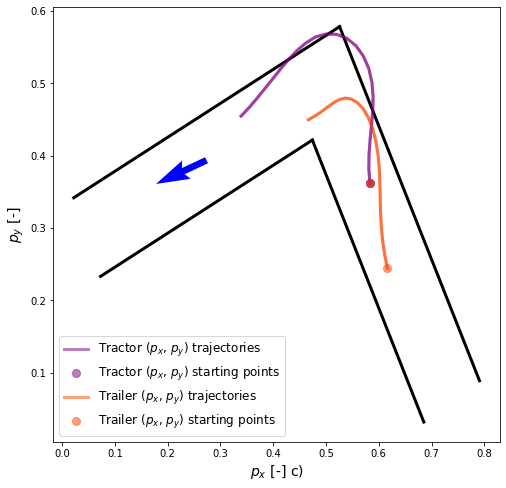

In [44]:
# Use random start states

# generate planning scenario, plan, and perform path following

goalDistThreshold = 0.1 # distance to goal when motion execution no longer performed
minDistThreshold = 0.7 # minimum distance threshold betwen start/goal
nLatSamples = 800 # number of samples to draw in latent space (when using nn)
p = 0.8 # likelihood which to sample from NN samples (when useNN is True)
nCtrlIter = 23
nPredictCtrlSteps = 23 # number of steps to simulate the car for using a single prediction

dt = 0.2 # controller time step
v =  0.1 # vehicle speed
L   = 0.05 # vehicle length constant
W   = 0.025 # truck/trailer width
Lt  = 0.20 # truck length constant
a11 = 0.5 * L
a12 = L - a11
b1  = 0.9 * a12
b2  = 0.5 * Lt 
a21 = Lt - b2
roadWidth = 0.12

planIdx = np.random.randint(numTrain, numEntries - 1)
goal = data[planIdx, -dimObs-dimGoal:-dimObs]
start = data[planIdx, :dim]

alpha1 = obsData[planIdx, 0]
alpha2 = obsData[planIdx, 1]
c = np.array([0.5, 0.5])

a = c[0] + 0.5 * np.array([np.cos(alpha1), np.sin(alpha1)]) # line segment 1 end point
b = c[1] + 0.5 * np.array([np.cos(alpha2), np.sin(alpha2)]) # line segment 2 end point

l1a = a.reshape(1,2)
l2a = c.reshape(1,2)
l1b = b.reshape(1,2)
l2b = np.copy(l2a)

sign = np.where(alpha1 < alpha2, 1, -1)
k = (1 / np.abs(np.sin(.5*(alpha1 - alpha2 + np.pi + np.pi) % (2 * np.pi) - np.pi)))

lcx = c[0] + sign * roadWidth / 2 * np.cos((alpha1 + alpha2)/2) * k
lcy = c[1] + sign * roadWidth / 2 * np.sin((alpha1 + alpha2)/2) * k
scx = c[0] - sign * roadWidth / 2 * np.cos((alpha1 + alpha2)/2) * k
scy = c[1] - sign * roadWidth / 2 * np.sin((alpha1 + alpha2)/2) * k

maxSteer = np.max(data[:, 3::dim])
minSteer = np.min(data[:, 3::dim])
steerAngles = np.linspace(minSteer, maxSteer, num=200)
ax1.quiver(currentState[0] * gridSize, currentState[1] * gridSize, np.cos(currentState[2]), np.sin(currentState[2]), color='red', scale=8.0, width=0.015)ns
statearr = np.zeros(shape=(nCtrlIter + 1, dim, nStarts))

animate = True
for i in range(nStarts):

    # slightly random startt
    startI = start + np.random.normal(scale=0.00, size=start.shape)
    
    truckState = VehicleState()
    truckState.x = startI[0]; truckState.y = startI[1]; truckState.yaw = startI[2]; truckState.v = v

    trailerState = VehicleState()
    trailerState.yaw = truckState.yaw
    trailerState.x = truckState.x - b1 * np.cos(truckState.yaw) - b2 * np.cos(trailerState.yaw)
    trailerState.y = truckState.y - b1 * np.sin(truckState.yaw) - b2 * np.sin(trailerState.yaw)

    statearr[0, :, i] = np.array([truckState.x, truckState.y, truckState.yaw, trailerState.yaw, 0, trailerState.x, trailerState.y])

    if animate:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8), gridspec_kw={'width_ratios': [3, 2]})
        camera = Camera(fig)

    nStepsFromPrediction = 0 # number of steps taken so far given last CVAE prediction
    for ctrlIter in range(nCtrlIter):
        currentState = statearr[ctrlIter, :, i]

        if nStepsFromPrediction % nPredictCtrlSteps == 0:
            nStepsFromPrediction = 0 # number of steps taken so far given last CVAE prediction

            condition = torch.from_numpy(np.repeat([np.concatenate((currentState, goal, obsData[planIdx, :]))], nLatSamples, axis=0)).float().to(DEVICE)
            predictedStates = network(torch.randn(nLatSamples, z_dim).to(DEVICE), condition, encode=False).cpu().detach().numpy()

            kdes = np.array([gaussian_kde(predictedStates[:, i * dim - 4]) for i in range(1, nPredictCtrlSteps + 1)])

        delta = steerAngles[np.argmax(kdes[nStepsFromPrediction].pdf(steerAngles))]

        if animate:
            truckX = statearr[:ctrlIter+1, ::dim, i]
            truckY = statearr[:ctrlIter+1, 1::dim, i]
            trailerX = statearr[:ctrlIter+1, dim-2::dim, i]
            trailerY = statearr[:ctrlIter+1, dim-1::dim, i]

            ax1.plot(truckX, truckY, color="purple", linewidth=3, alpha=0.5)
            ax1.plot(truckX[0], truckY[0], 'o', color="purple", markersize=8, alpha=0.5)
            ax1.plot(trailerX, trailerY, color="orangered", linewidth=3, alpha=0.5)
            ax1.plot(trailerX[0], trailerY[0], 'o', color="orangered", markersize=8, alpha=0.5)

            ax1.scatter(predictedStates[:,::dim], predictedStates[:,1::dim], color='green', s=70, alpha=0.01) # nn samples
            rectTruck = patches.Rectangle((truckState.x - np.cos(truckState.yaw) * L/2 + np.sin(truckState.yaw) * W/2, 
                truckState.y - np.cos(truckState.yaw) * W/2 - np.sin(truckState.yaw) * L/2), L, W, angle=np.rad2deg(truckState.yaw), color='purple', alpha=0.8, label='Vehicle')
            rectTrailer = patches.Rectangle((truckState.x - b1 * np.cos(truckState.yaw) - b2 / 2 * np.cos(trailerState.yaw) - np.cos(trailerState.yaw) * b2/2 + np.sin(trailerState.yaw) * W/2, 
                        truckState.y - b1 * np.sin(truckState.yaw) - b2 / 2 * np.sin(trailerState.yaw) - np.cos(trailerState.yaw) * W/2 - np.sin(trailerState.yaw) * b2/2), b2, W, angle=np.rad2deg(trailerState.yaw), color='orangered', alpha=0.8, label='Trailer')
            ax1.add_patch(rectTruck)
            ax1.add_patch(rectTrailer)
            ax1.quiver(goal[0], goal[1], np. cos(goal[2]), np.sin(goal[2]), color='blue', scale=8.0, width=0.015)
            ax1.plot([a[0] + roadWidth / 2 * np.sin(alpha1), scx], [a[1] - roadWidth / 2 * np.cos(alpha1), scy], color='k', linewidth=3)
            ax1.plot([a[0] - roadWidth / 2 * np.sin(alpha1), lcx], [a[1] + roadWidth / 2 * np.cos(alpha1), lcy], color='k', linewidth=3)
            ax1.plot([b[0] + roadWidth / 2 * np.sin(alpha2), lcx], [b[1] - roadWidth / 2 * np.cos(alpha2), lcy], color='k', linewidth=3)
            ax1.plot([b[0] - roadWidth / 2 * np.sin(alpha2), scx], [b[1] + roadWidth / 2 * np.cos(alpha2), scy], color='k', linewidth=3)
            ax1.set_xlabel('x', fontsize=12)
            ax1.set_ylabel('y', fontsize=12)
            ax2.plot(steerAngles, kdes[nStepsFromPrediction].pdf(steerAngles), color='C0')
            ax2.set_xlabel('Steering angle', fontsize=12)
            ax2.set_ylabel('Sample density', fontsize=12)
            camera.snap()


        beta = np.arctan(np.tan(delta) * a12 / (a11 + a12))

        trailerState.x = truckState.x - b1 * np.cos(truckState.yaw) - b2 * np.cos(trailerState.yaw)
        trailerState.y = truckState.y - b1 * np.sin(truckState.yaw) - b2 * np.sin(trailerState.yaw)
        trailerState.yaw += (v * np.sin(truckState.yaw - trailerState.yaw) / (b2 + a21) - v * (b1 - a12) * np.cos(truckState.yaw - trailerState.yaw) * np.sin(beta) / (a12 * (b2 + a21))) * dt

        truckState.x += v * np.cos(truckState.yaw + beta) * dt
        truckState.y += v * np.sin(truckState.yaw + beta) * dt
        truckState.yaw += v * np.sin(beta) / a12 * dt

        statearr[ctrlIter+1, :, i] = np.array([truckState.x, truckState.y, truckState.yaw, trailerState.yaw, delta, trailerState.x, trailerState.y])
        nStepsFromPrediction += 1

    if animate:        
        fps = 10
        animation = camera.animate(interval=2000/fps)
        print("saving animation")
        animation.save('animation.mp4')

fig = plt.figure(figsize=(8,8))
plt.quiver(goal[0], goal[1], np. cos(goal[2]), np.sin(goal[2]), color='blue', scale=8.0, width=0.015)
plt.plot([a[0] + roadWidth / 2 * np.sin(alpha1), scx], [a[1] - roadWidth / 2 * np.cos(alpha1), scy], color='k', linewidth=3)
plt.plot([a[0] - roadWidth / 2 * np.sin(alpha1), lcx], [a[1] + roadWidth / 2 * np.cos(alpha1), lcy], color='k', linewidth=3)
plt.plot([b[0] + roadWidth / 2 * np.sin(alpha2), lcx], [b[1] - roadWidth / 2 * np.cos(alpha2), lcy], color='k', linewidth=3)
plt.plot([b[0] - roadWidth / 2 * np.sin(alpha2), scx], [b[1] + roadWidth / 2 * np.cos(alpha2), scy], color='k', linewidth=3)
plt.xlabel('$p_x$ [-] c)', fontsize=14)
plt.ylabel('$p_y$ [-]', fontsize=14)
for i in range(nStarts):
    truckX = statearr[:, ::dim, i]
    truckY = statearr[:, 1::dim, i]
    trailerX = statearr[:, dim-2::dim, i]
    trailerY = statearr[:, dim-1::dim, i]
    plt.plot(truckX, truckY, color="purple", linewidth=3, alpha=0.5)
    plt.plot(truckX[0], truckY[0], 'o', color="purple", markersize=8, alpha=0.5)
    plt.plot(trailerX, trailerY, color="orangered", linewidth=3, alpha=0.5)
    plt.plot(trailerX[0], trailerY[0], 'o', color="orangered", markersize=8, alpha=0.5)

plt.plot(truckX, truckY, color="purple", linewidth=3,  alpha=0.5, label='Tractor ($p_x$, $p_y$) trajectories')
plt.plot(truckX[0], truckY[0], 'o', color="purple", markersize=8,  alpha=0.5, label='Tractor ($p_x$, $p_y$) starting points')
plt.plot(trailerX, trailerY, color="orangered", linewidth=3,  alpha=0.5, label='Trailer ($p_x$, $p_y$) trajectories')
plt.plot(truckX[0], truckY[0], 'o', color="orangered", markersize=8,  alpha=0.5, label='Trailer ($p_x$, $p_y$) starting points')

plt.legend(fontsize=12)
plt.show()


In [29]:
print(statearr)

[[[ 4.44103000e-01]
  [ 6.92030000e-01]
  [-1.28753900e+00]
  [-1.28753900e+00]
  [ 0.00000000e+00]
  [ 4.09866131e-01]
  [ 8.09648395e-01]]

 [[ 4.45873509e-01]
  [ 6.72108522e-01]
  [-1.44225073e+00]
  [-1.28947290e+00]
  [-3.75514945e-01]
  [ 4.09866131e-01]
  [ 8.09648395e-01]]

 [[ 4.45140848e-01]
  [ 6.52121946e-01]
  [-1.57380003e+00]
  [-1.30631653e+00]
  [-3.21821131e-01]
  [ 4.15226462e-01]
  [ 7.90491769e-01]]

 [[ 4.42359477e-01]
  [ 6.32316291e-01]
  [-1.68267477e+00]
  [-1.33405959e+00]
  [-2.68127317e-01]
  [ 4.19067712e-01]
  [ 7.71144706e-01]]

 [[ 4.38527895e-01]
  [ 6.12686747e-01]
  [-1.74731809e+00]
  [-1.36897869e+00]
  [-1.60739688e-01]
  [ 4.21418330e-01]
  [ 7.51886473e-01]]

 [[ 4.35019130e-01]
  [ 5.92996938e-01]
  [-1.74718139e+00]
  [-1.40591488e+00]
  [ 3.41753769e-04]
  [ 4.22433999e-01]
  [ 7.32807492e-01]]

 [[ 4.33119115e-01]
  [ 5.73087394e-01]
  [-1.68226020e+00]
  [-1.43861825e+00]
  [ 1.61423196e-01]
  [ 4.22553709e-01]
  [ 7.13791621e-01]]

 [[ 4.

In [ ]:
!